In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(14)

In [2]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report, roc_auc_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report, roc_auc_score, recall_score, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import dalex as dx
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import EnsembleVoteClassifier

In [12]:
houses_df = pd.read_csv('https://github.com/FylypO/DVT---Project/blob/main/HousePriceIndia.csv?raw=true')
df, target = data_preprocess(houses_df)
train, validation = train_test_split(df, test_size=0.2, stratify=target, random_state=14)
houses_df = train
target = np.array(houses_df["Price Category"])

## **Functions**

In [4]:
def data_preprocess(df):

    result = df.copy()

    Q1 = np.percentile(result["Price"], 25)
    Q3 = np.percentile(result["Price"], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR        # poniżej outliery
    upper_bound = Q3 + 1.5 * IQR        # powyżej outliery
    lower_bound = max(0, lower_bound)
    threshold1 = lower_bound + (upper_bound - lower_bound) / 3
    threshold2 = lower_bound + (upper_bound - lower_bound) / 3 * 2
    labels = [0,1,2]
    bins = [-float("inf"), threshold1, threshold2, float("inf")]
    result["Price Category"] = pd.cut(result["Price"], bins=bins, labels=labels, include_lowest=True)

    result['Renovated'] = [1 if e > 0 else 0 for e in result['Renovation Year']]

    result = result.drop(columns=['id', 'Date','Renovation Year', 'Price'])
    
    target = np.array(result["Price Category"])

    return result, target

In [5]:
def train_test_splitter(df, fraction):
    X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = fraction, random_state = 14, stratify = target)
    return X_train.drop(columns='Price Category'), X_test.drop(columns='Price Category'), y_train, y_test

In [6]:
def get_pipeline(model):

  normal = ['number of bedrooms', 'number of bathrooms', 'living area', 'grade of the house', 'Lattitude', 'Longitude', 'living_area_renov', 'lot area', 'Area of the house(excluding basement)', 'lot_area_renov']
  numerical = ['number of floors', 'number of views', 'Area of the basement', 'Postal Code', 'condition of the house', 'Built Year', 'Distance from the airport']
  categorical = ['waterfront present', 'Renovated', 'Number of schools nearby']

  #Ustalamy transformacje kolumn
  preprocessor = ColumnTransformer(
    transformers=[
      ('normal', StandardScaler(), normal),
      ('numerical', MinMaxScaler(), numerical),
      ('categorical', OneHotEncoder(), categorical)])

  #Tworzymy pipeline z transformacją i modelem  
  pipeline = Pipeline(steps=[('transformer', preprocessor), ('model', model)])
  return pipeline

In [7]:
def columns(model, dN):
    X_train, X_test, y_train, y_test = train_test_splitter(houses_df, 0.2)
    test = get_pipeline(model)
    test.fit(X_train, y_train)
    exp = dx.Explainer(test, X_train, y_train, verbose=False)
    vi = exp.model_parts(N = dN, B = 20, random_state=14)
    return vi.result

In [8]:
def first_model_tester(df, model, test_param, model_grid, name):

  #Podział na train i test
  X_train, X_test, y_train, y_test = train_test_splitter(df, 0.2)

  #Przekazujemy parametry do modelu
  test_model = model(**test_param)

  test = get_pipeline(test_model)

  #Random search
  random = RandomizedSearchCV(test, model_grid, n_iter=10, cv=5, scoring='recall', n_jobs=-1, random_state=14)
  random.fit(X_train,y_train)

  #Wybieramy najlepsze parametry  
  best = random.best_params_

  #Tworzymy model z najlepszymi parametrami
  parameters = dict()
  for param in best.keys():
      parameters[param.replace("model__","")] = best[param]

  best_model = model(**parameters)
  
  #Zmieniamy model w pipeline
  test = get_pipeline(best_model)

  #Cross validation
  folds = KFold(n_splits=10, shuffle=True, random_state=14)
  cv = cross_val_score(test, X_train, y_train, cv=folds, scoring='accuracy', n_jobs=-1)

  #Sprawdzamy model z najlepszymi parametrami
  test.fit(X_train, y_train)
  y_pred = test.predict(X_test)
  y_pred_prob = test.predict_proba(X_test)

  #Wyniki dla cross validacji
  print(f"średnia dokładności podczas cross validacji dla {str(name)} z najlepszymi parametrami z random searcha: {round(np.mean(cv), 5)}"
    f"\n min: {round(min(cv), 5)} max: {round(max(cv), 5)}")

  #Wyniki dla modelu z najlepszymi parametrami
  print(f"{classification_report(y_test, y_pred)}")
  print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_prob, multi_class='ovr')}\n")
  print(f"confusion_matrix:\n {confusion_matrix(y_test, y_pred)}")

  return parameters

## **Logistic Regression**

In [9]:
test_param_lr = {
                "random_state": 14,
                "max_iter": 1000,
                }
                
model_grid_lr = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'model__penalty': ['l1', 'l2', None],
    'model__class_weight': ['balanced', None],
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                }

In [13]:
param_lr = first_model_tester(houses_df, LogisticRegression, test_param_lr, model_grid_lr, "Logistic Regression")

średnia dokładności podczas cross validacji dla Logistic Regression z najlepszymi parametrami z random searcha: 0.77747
 min: 0.75401 max: 0.79701
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       849
           1       0.81      0.73      0.76      1107
           2       0.70      0.85      0.77       384

    accuracy                           0.79      2340
   macro avg       0.77      0.81      0.79      2340
weighted avg       0.79      0.79      0.79      2340

roc_auc_score: 0.9266855833822181

confusion_matrix:
 [[709 139   1]
 [161 804 142]
 [  2  54 328]]


In [14]:
columns(LogisticRegression(**param_lr), None)

,variable,dropout_loss,label
0,grade of the house,0.229800,LogisticRegression
1,Area of the house(excluding basement),0.236298,LogisticRegression
2,living_area_renov,0.257660,LogisticRegression
3,living area,0.288386,LogisticRegression
4,Renovated,0.296010,LogisticRegression
5,number of bedrooms,0.297333,LogisticRegression
6,Number of schools nearby,0.299826,LogisticRegression
7,_full_model_,0.300138,LogisticRegression
8,Distance from the airport,0.300236,LogisticRegression
9,waterfront present,0.300257,LogisticRegression


## **Decision Tree**

In [14]:
test_param_dt = {
    "random_state": 14
}

model_grid_dt = {
    'model__criterion': ['gini', 'entropy'],
    'model__splitter': ['best', 'random'],
    'model__max_depth': [None, 2, 4, 6, 8, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__class_weight': ['balanced', None]
}

In [15]:
param_dt = first_model_tester(houses_df, DecisionTreeClassifier, test_param_dt, model_grid_dt, "Decision Tree")

średnia dokładności podczas cross validacji dla Decision Tree z najlepszymi parametrami z random searcha: 0.7267
 min: 0.7062 max: 0.74573
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       849
           1       0.69      0.75      0.72      1107
           2       0.66      0.66      0.66       384

    accuracy                           0.72      2340
   macro avg       0.71      0.70      0.71      2340
weighted avg       0.72      0.72      0.72      2340

roc_ruc_score: 0.8029242339721824

confusion_matrix:
 [[601 246   2]
 [153 825 129]
 [  6 125 253]]


In [16]:
columns(DecisionTreeClassifier(**param_dt), None)

,variable,dropout_loss,label
0,grade of the house,0.173554,DecisionTreeClassifier
1,_baseline_,0.498881,DecisionTreeClassifier
2,Area of the basement,0.600795,DecisionTreeClassifier
3,number of floors,0.600795,DecisionTreeClassifier
4,number of bedrooms,0.600795,DecisionTreeClassifier
5,number of bathrooms,0.600795,DecisionTreeClassifier
6,lot_area_renov,0.600795,DecisionTreeClassifier
7,lot area,0.600795,DecisionTreeClassifier
8,living_area_renov,0.600795,DecisionTreeClassifier
9,living area,0.600795,DecisionTreeClassifier


## **KNN**

In [18]:
test_param_knn = {
}

model_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'model__leaf_size': [10, 20, 30, 40],
    'model__p': [1, 2]
}

In [19]:
param_knn = first_model_tester(houses_df, KNeighborsClassifier, test_param_knn, model_grid_knn, "KNN")

średnia dokładności podczas cross validacji dla KNN z najlepszymi parametrami z random searcha: 0.81702
 min: 0.80021 max: 0.83957
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       849
           1       0.81      0.84      0.82      1107
           2       0.87      0.72      0.79       384

    accuracy                           0.83      2340
   macro avg       0.84      0.81      0.82      2340
weighted avg       0.83      0.83      0.83      2340

roc_ruc_score: 0.9307101324374343

confusion_matrix:
 [[732 117   0]
 [137 929  41]
 [  2 104 278]]


In [24]:
columns(KNeighborsClassifier(**param_knn), 1000)

,variable,dropout_loss,label
0,grade of the house,0.058590,KNeighborsClassifier
1,Area of the house(excluding basement),0.080599,KNeighborsClassifier
2,living area,0.084431,KNeighborsClassifier
3,number of views,0.106772,KNeighborsClassifier
4,Longitude,0.106819,KNeighborsClassifier
5,living_area_renov,0.106946,KNeighborsClassifier
6,Built Year,0.107344,KNeighborsClassifier
7,lot_area_renov,0.108796,KNeighborsClassifier
8,Area of the basement,0.108822,KNeighborsClassifier
9,condition of the house,0.109008,KNeighborsClassifier


## **SVC**

In [15]:
test_param_svc = {
    "random_state": 14
}

model_grid_svc = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__gamma': ['scale', 'auto'],
    'model__degree': [2, 3, 4],
    'model__class_weight': [None, 'balanced'],
    'model__probability': [True]
}

In [16]:
param_svc = first_model_tester(houses_df, SVC, test_param_svc, model_grid_svc, "SVC")

średnia dokładności podczas cross validacji dla SVC z najlepszymi parametrami z random searcha: 0.83946
 min: 0.82353 max: 0.86111
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       849
           1       0.86      0.81      0.83      1107
           2       0.77      0.88      0.82       384

    accuracy                           0.85      2340
   macro avg       0.83      0.86      0.84      2340
weighted avg       0.85      0.85      0.85      2340

roc_auc_score: 0.9615369204541487

confusion_matrix:
 [[749 100   0]
 [109 896 102]
 [  3  45 336]]


In [28]:
columns(SVC(**param_svc), 100)

,variable,dropout_loss,label
0,Area of the house(excluding basement),-0.004245,SVC
1,grade of the house,0.041695,SVC
2,Longitude,0.043742,SVC
3,Built Year,0.053474,SVC
4,number of bathrooms,0.070403,SVC
5,lot_area_renov,0.070936,SVC
6,number of views,0.074240,SVC
7,living area,0.075456,SVC
8,waterfront present,0.077805,SVC
9,Renovated,0.079233,SVC


## **Random Forest**

In [17]:
test_param_rf = {
    "random_state": 14,
    "n_jobs": -1
}

model_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2'],
    'model__bootstrap': [True, False],
    'model__criterion': ["gini", "entropy"]
}

In [30]:
param_rf = first_model_tester(houses_df, RandomForestClassifier, test_param_rf, model_grid_rf, "Random Forest")  

średnia dokładności podczas cross validacji dla Random Forest z najlepszymi parametrami z random searcha: 0.8572
 min: 0.83957 max: 0.87714
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       849
           1       0.83      0.89      0.86      1107
           2       0.89      0.74      0.81       384

    accuracy                           0.86      2340
   macro avg       0.87      0.84      0.85      2340
weighted avg       0.87      0.86      0.86      2340

roc_ruc_score: 0.9658900692062927

confusion_matrix:
 [[747 102   0]
 [ 84 989  34]
 [  1 100 283]]


In [32]:
columns(RandomForestClassifier(**param_rf), 1000)

,variable,dropout_loss,label
0,grade of the house,0.009238,RandomForestClassifier
1,living area,0.042973,RandomForestClassifier
2,Area of the house(excluding basement),0.069147,RandomForestClassifier
3,living_area_renov,0.080754,RandomForestClassifier
4,number of views,0.093019,RandomForestClassifier
5,number of bedrooms,0.096477,RandomForestClassifier
6,Renovated,0.098959,RandomForestClassifier
7,_full_model_,0.099153,RandomForestClassifier
8,waterfront present,0.099504,RandomForestClassifier
9,Distance from the airport,0.099667,RandomForestClassifier


## **AdaBoost**

In [33]:
test_param_ab = {
    "random_state": 14
}

model_grid_ab = {
    'model__n_estimators': [50, 100, 150],
    'model__learning_rate': [0.01, 0.1, 1.0, 2.0],
    'model__algorithm': ['SAMME', 'SAMME.R']
}

In [34]:
param_ab = first_model_tester(houses_df, AdaBoostClassifier, test_param_ab, model_grid_ab, "AdaBoost")

średnia dokładności podczas cross validacji dla AdaBoost z najlepszymi parametrami z random searcha: 0.65338
 min: 0.62353 max: 0.68556
              precision    recall  f1-score   support

           0       0.85      0.66      0.74       849
           1       0.60      0.88      0.71      1107
           2       0.25      0.05      0.08       384

    accuracy                           0.66      2340
   macro avg       0.57      0.53      0.51      2340
weighted avg       0.63      0.66      0.62      2340

roc_ruc_score: 0.8647234858885892

confusion_matrix:
 [[561 276  12]
 [ 97 969  41]
 [  3 363  18]]


In [36]:
columns(AdaBoostClassifier(**param_ab), 1000)

,variable,dropout_loss,label
0,grade of the house,-0.206508,AdaBoostClassifier
1,Area of the basement,-0.067804,AdaBoostClassifier
2,number of floors,-0.067804,AdaBoostClassifier
3,number of bedrooms,-0.067804,AdaBoostClassifier
4,number of bathrooms,-0.067804,AdaBoostClassifier
5,lot_area_renov,-0.067804,AdaBoostClassifier
6,lot area,-0.067804,AdaBoostClassifier
7,living_area_renov,-0.067804,AdaBoostClassifier
8,condition of the house,-0.067804,AdaBoostClassifier
9,number of views,-0.067804,AdaBoostClassifier


## **GradientBoost**

In [18]:
test_param_gb = {
    "random_state": 14
}

model_grid_gb = {
    'model__n_estimators': [50, 100, 150],
    'model__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

In [38]:
param_gb = first_model_tester(houses_df, GradientBoostingClassifier, test_param_gb, model_grid_gb, "GradientBoost")

średnia dokładności podczas cross validacji dla GradientBoost z najlepszymi parametrami z random searcha: 0.8665
 min: 0.85348 max: 0.88996
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       849
           1       0.85      0.90      0.88      1107
           2       0.90      0.80      0.85       384

    accuracy                           0.88      2340
   macro avg       0.89      0.86      0.87      2340
weighted avg       0.88      0.88      0.88      2340

roc_ruc_score: 0.9696073249128041

confusion_matrix:
 [[755  94   0]
 [ 77 996  34]
 [  2  75 307]]


In [41]:
columns(GradientBoostingClassifier(**param_gb), 1000)

,variable,dropout_loss,label
0,grade of the house,0.019830,GradientBoostingClassifier
1,Area of the house(excluding basement),0.107310,GradientBoostingClassifier
2,living_area_renov,0.123406,GradientBoostingClassifier
3,living area,0.140569,GradientBoostingClassifier
4,number of views,0.142236,GradientBoostingClassifier
5,Longitude,0.149296,GradientBoostingClassifier
6,Built Year,0.151448,GradientBoostingClassifier
7,number of bathrooms,0.153231,GradientBoostingClassifier
8,lot area,0.155477,GradientBoostingClassifier
9,Renovated,0.156705,GradientBoostingClassifier


## **XGBoost**

In [19]:
test_param_xgb = {
    "random_state": 14
}

model_grid_xgb = {
    'model__n_estimators': [50, 100, 150],
    'model__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'model__max_depth': [3, 5, 7],
    'model__min_child_weight': [1, 3, 5],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2, 0.3],
    'model__reg_alpha': [0, 0.1, 0.5, 1.0],
    'model__reg_lambda': [0.01, 0.1, 1, 10]
}


In [20]:
test_param_xgb = {
    "random_state": 14
}

model_grid_xgb = {
    'model__n_estimators': [50, 100],
    'model__learning_rate': [0.01, 0.1, 0.5],
    'model__max_depth': [3, 5],
    'model__min_child_weight': [1, 3],
    'model__subsample': [0.6, 0.8],
    'model__colsample_bytree': [0.6, 0.8],
    'model__gamma': [0, 0.1],
    'model__reg_alpha': [0, 0.1],
    'model__reg_lambda': [0.01, 0.1]
}


In [52]:
param_xgb = first_model_tester(houses_df, XGBClassifier, test_param_xgb, model_grid_xgb, "XGBoost")

średnia dokładności podczas cross validacji dla XGBoost z najlepszymi parametrami z random searcha: 0.83208
 min: 0.81497 max: 0.8547
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       849
           1       0.79      0.89      0.84      1107
           2       0.89      0.66      0.76       384

    accuracy                           0.84      2340
   macro avg       0.86      0.80      0.82      2340
weighted avg       0.84      0.84      0.84      2340

roc_auc_score: 0.9506711987868662

confusion_matrix:
 [[714 135   0]
 [ 85 989  33]
 [  0 129 255]]


In [53]:
columns(XGBClassifier(**param_xgb), None)

,variable,dropout_loss,label
0,grade of the house,-0.048386,XGBClassifier
1,living area,0.060372,XGBClassifier
2,Area of the house(excluding basement),0.093502,XGBClassifier
3,living_area_renov,0.099540,XGBClassifier
4,Longitude,0.105529,XGBClassifier
5,Built Year,0.111804,XGBClassifier
6,number of bathrooms,0.112083,XGBClassifier
7,number of views,0.114078,XGBClassifier
8,condition of the house,0.115206,XGBClassifier
9,Distance from the airport,0.115277,XGBClassifier


## **Dostrajanie parametrów dla RandomForest i XGBoost**

Po przeanalizowaniu wyników, stwierdzamy, że najlepsze wyniki otrzymujemy używając RandomForestClassifier i XGBCalssifier. Teraz spróbujemy znaleźć dla nich optymalne hiperparametry.

Zauważamy, że nawet mało znaczące kolumny nie wpływają negatywie na wyniki modelu, a nawet nieznacznie pomagają, więc nie ma potrzeby ich usuwania

In [21]:
def best_param(df, model, test_param, model_grid):
  X_train, X_test, y_train, y_test = train_test_splitter(df, 0.2)
  test_model = model(**test_param)
  test = get_pipeline(test_model)
  grid = GridSearchCV(test, model_grid, cv=2, verbose=4)
  grid.fit(X_train,y_train)
  best = grid.best_params_
  parameters = dict()
  for param in best.keys():
      parameters[param.replace("model__","")] = best[param]
  best_model = model(**parameters)
  test = get_pipeline(best_model)
  test.fit(X_train, y_train)
  y_pred = test.predict(X_test)
  y_pred_prob = test.predict_proba(X_test)
  print(f"{classification_report(y_test, y_pred)}")
  print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_prob, multi_class='ovr')}\n")
  print(f"confusion_matrix:\n {confusion_matrix(y_test, y_pred)}")
  return parameters

In [22]:
best_svc = best_param(houses_df, SVC, test_param_svc, model_grid_svc)

Fitting 2 folds for each of 108 candidates, totalling 216 fits
[CV 1/2] END model__C=0.1, model__class_weight=None, model__degree=2, model__gamma=scale, model__kernel=linear, model__probability=True;, score=0.799 total time=   0.7s
[CV 2/2] END model__C=0.1, model__class_weight=None, model__degree=2, model__gamma=scale, model__kernel=linear, model__probability=True;, score=0.795 total time=   0.6s
[CV 1/2] END model__C=0.1, model__class_weight=None, model__degree=2, model__gamma=scale, model__kernel=rbf, model__probability=True;, score=0.798 total time=   1.9s
[CV 2/2] END model__C=0.1, model__class_weight=None, model__degree=2, model__gamma=scale, model__kernel=rbf, model__probability=True;, score=0.793 total time=   1.8s
[CV 1/2] END model__C=0.1, model__class_weight=None, model__degree=2, model__gamma=scale, model__kernel=poly, model__probability=True;, score=0.801 total time=   0.8s
[CV 2/2] END model__C=0.1, model__class_weight=None, model__degree=2, model__gamma=scale, model__ker

In [23]:
best_xgb = best_param(houses_df, XGBClassifier, test_param_xgb, model_grid_xgb)

Fitting 2 folds for each of 768 candidates, totalling 1536 fits
[CV 1/2] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=50, model__reg_alpha=0, model__reg_lambda=0.01, model__subsample=0.6;, score=0.808 total time=   0.0s
[CV 2/2] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=50, model__reg_alpha=0, model__reg_lambda=0.01, model__subsample=0.6;, score=0.794 total time=   0.0s
[CV 1/2] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=50, model__reg_alpha=0, model__reg_lambda=0.01, model__subsample=0.8;, score=0.808 total time=   0.0s
[CV 2/2] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=50, model__reg_alpha=0

In [24]:
best_gb = best_param(houses_df, GradientBoostingClassifier, test_param_gb, model_grid_gb)

Fitting 2 folds for each of 972 candidates, totalling 1944 fits
[CV 1/2] END model__learning_rate=0.01, model__max_depth=3, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50;, score=nan total time=   0.0s
[CV 2/2] END model__learning_rate=0.01, model__max_depth=3, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50;, score=nan total time=   0.0s
[CV 1/2] END model__learning_rate=0.01, model__max_depth=3, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/2] END model__learning_rate=0.01, model__max_depth=3, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/2] END model__learning_rate=0.01, model__max_depth=3, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_esti

In [25]:
best_rf = best_param(houses_df, RandomForestClassifier, test_param_rf, model_grid_rf)

Fitting 2 folds for each of 648 candidates, totalling 1296 fits
[CV 1/2] END model__bootstrap=True, model__criterion=gini, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.858 total time=   0.0s
[CV 2/2] END model__bootstrap=True, model__criterion=gini, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.849 total time=   0.0s
[CV 1/2] END model__bootstrap=True, model__criterion=gini, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200;, score=0.863 total time=   0.2s
[CV 2/2] END model__bootstrap=True, model__criterion=gini, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200;, score=0.852 total time=   0.1s
[CV 1/2] END model__bootstrap=True, model__criterion=gin

## **Voting**

### With SVC

In [39]:
X_train, X_test, y_train, y_test = train_test_splitter(houses_df, 0.2)

normal = ['number of bedrooms', 'number of bathrooms', 'living area', 'grade of the house', 'Lattitude', 'Longitude', 'living_area_renov', 'lot area', 'Area of the house(excluding basement)', 'lot_area_renov']
numerical = ['number of floors', 'number of views', 'Area of the basement', 'Postal Code', 'condition of the house', 'Built Year', 'Distance from the airport']
categorical = ['waterfront present', 'Renovated', 'Number of schools nearby']

preprocessor = ColumnTransformer(
  transformers=[
    ('normal', StandardScaler(), normal),
    ('numerical', MinMaxScaler(), numerical),
    ('categorical', OneHotEncoder(), categorical)])

rf_model = RandomForestClassifier(**best_rf)
gb_model = GradientBoostingClassifier(**best_gb)
xgb_model = XGBClassifier(**best_xgb)
svc_model = SVC(**best_svc)

final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting_clf', EnsembleVoteClassifier(clfs=[rf_model, gb_model, xgb_model, svc_model], voting='soft', weights=[0.3, 0.3, 0.3, 0.1], fit_base_estimators=True))
])
final_model.fit(X_train, y_train)
y_hat_v = final_model.predict(X_test)
y_hat_prob_v = final_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_hat_v))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       849
           1       0.86      0.90      0.88      1107
           2       0.91      0.81      0.85       384

    accuracy                           0.88      2340
   macro avg       0.89      0.87      0.88      2340
weighted avg       0.88      0.88      0.88      2340



### Without SVC

In [94]:
X_train, X_test, y_train, y_test = train_test_splitter(houses_df, 0.2)

normal = ['number of bedrooms', 'number of bathrooms', 'living area', 'grade of the house', 'Lattitude', 'Longitude', 'living_area_renov', 'lot area', 'Area of the house(excluding basement)', 'lot_area_renov']
numerical = ['number of floors', 'number of views', 'Area of the basement', 'Postal Code', 'condition of the house', 'Built Year', 'Distance from the airport']
categorical = ['waterfront present', 'Renovated', 'Number of schools nearby']

preprocessor = ColumnTransformer(
  transformers=[
    ('normal', StandardScaler(), normal),
    ('numerical', MinMaxScaler(), numerical),
    ('categorical', OneHotEncoder(), categorical)])

rf_model = RandomForestClassifier(**best_rf)
gb_model = GradientBoostingClassifier(**best_gb)
xgb_model = XGBClassifier(**best_xgb)

final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting_clf', EnsembleVoteClassifier(clfs=[rf_model, gb_model, xgb_model], voting='soft', weights=[0.3, 0.4, 0.3], fit_base_estimators=True))
])
final_model.fit(X_train, y_train)
y_hat_v = final_model.predict(X_test)
y_hat_prob_v = final_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_hat_v))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       849
           1       0.86      0.90      0.88      1107
           2       0.90      0.81      0.85       384

    accuracy                           0.88      2340
   macro avg       0.89      0.87      0.88      2340
weighted avg       0.88      0.88      0.88      2340



## XAI

In [ ]:
exp = dx.Explainer(final_model, X_train, y_train, verbose=False)
vi = exp.model_parts(N = None, B = 20, random_state=14)
vi.result

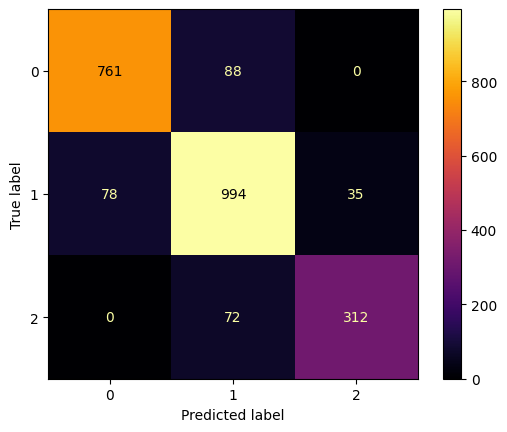

In [95]:
cm = confusion_matrix(y_test, y_hat_v)
plot = ConfusionMatrixDisplay(confusion_matrix=cm)
plot.plot(cmap="inferno")